In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
# from torchvision.transforms import v2
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data_dir = "drive/MyDrive/Melanoma/dataset_seg_mid"
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir,transform_image=None, transform_mask=None):
        self.image_dir = os.path.join(image_dir, 'images')  
        self.mask_dir = os.path.join(mask_dir, 'images')  
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.images = [f for f in os.listdir(self.image_dir) if f.lower().endswith('.jpg')]  # Only .jpg files

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
#         print(f"Loading image >>>>>>>>>>>>>>>> {img_name}")
        image = Image.open(img_name).convert('RGB')

        # Construct the mask filename with _Segmentation.png suffix
        mask_name = self.images[idx].replace('.jpg', '_Segmentation.png')
        mask_name = os.path.join(self.mask_dir, mask_name)
#         print(f"Loading mask >>>>>>>>>>>>>>>>>> {mask_name}")
        mask = Image.open(mask_name).convert('L')  # Convert to grayscale for masks

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)


        # print(f"Image shape: {image.size()}")  # Tensor shape should be [3, H, W]
        # print(f"Mask shape: {mask.size()}")    # Tensor shape should be [1, H, W]


        return image, mask


In [ ]:
from torch.nn import functional as F

def double_conv(in_channels, out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True))

    return conv

def crop_tensor(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[
        :,
        :,
        delta:tensor_size-delta,
        delta: tensor_size-delta
    ]

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.down_conv_1 = double_conv(3,64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128,256)
        self.down_conv_4 = double_conv(256,512)
        self.down_conv_5 = double_conv(512,1024)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )

        self.up_conv_1 = double_conv(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )

        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        )

        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )

        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=out_channels,
            kernel_size=1
        )


    def forward(self, image):
        #encoder
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)

        #decoder
        x = self.up_trans_1(x9)
        y = crop_tensor(x7, x)
        x = self.up_conv_1(torch.cat([x,y], axis=1))

        x = self.up_trans_2(x)
        y = crop_tensor(x5, x)
        x = self.up_conv_2(torch.cat([x,y], axis=1))

        x = self.up_trans_3(x)
        y = crop_tensor(x3, x)
        x = self.up_conv_3(torch.cat([x,y], axis=1))

        x = self.up_trans_4(x)
        y = crop_tensor(x1, x)
        x = self.up_conv_4(torch.cat([x,y], axis=1))

        #output
        out = self.out(x)

        return out



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import random

# Define custom transform function for paired image and mask
class RandomTransform:
    def __init__(self, image_transform, mask_transform=None):
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __call__(self, image, mask):
        # Apply the same random transformation to both image and mask
        seed = random.randint(0, 2**32)
        random.seed(seed)
        torch.manual_seed(seed)
        image = self.image_transform(image)

        if self.mask_transform:
            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.mask_transform(mask)

        return image, mask

# SegmentationDataset with consistent transforms for image and mask
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = os.path.join(image_dir, 'images')  # Adjust if necessary
        self.mask_dir = os.path.join(mask_dir, 'images')    # Adjust if necessary
        self.transform = transform
        self.images = [f for f in os.listdir(self.image_dir) if f.lower().endswith('.jpg')]  # Only .jpg files

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        # Construct the mask filename with _Segmentation.png suffix
        mask_name = self.images[idx].replace('.jpg', '_Segmentation.png')
        mask_name = os.path.join(self.mask_dir, mask_name)
        mask = Image.open(mask_name).convert('L')  # Convert to grayscale for masks

        # Apply the transformations if they are provided
        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

# Define  base transforms
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop((256, 256), scale=(0.8, 1.0)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop((256, 256), scale=(0.8, 1.0)),
    transforms.ToTensor()
])

# Apply the same transformations to both image and mask
transform = RandomTransform(image_transforms, mask_transforms)

# Create dataset instances
data_dir = "drive/MyDrive/Melanoma/dataset_seg_mid"
batch_size = 4
image_datasets = {
    'train': SegmentationDataset(
        os.path.join(data_dir, 'train'),
        os.path.join(data_dir, 'train_groundtruth'),
        transform=transform
    ),
    'test': SegmentationDataset(
        os.path.join(data_dir, 'test'),
        os.path.join(data_dir, 'test_groundtruth'),
        transform=transform
    )
}

# Create dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'],
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    ),
    'test': torch.utils.data.DataLoader(
        image_datasets['test'],
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
}

# Calculate dataset sizes
dataset_size = {
    'train': len(image_datasets['train']),
    'test': len(image_datasets['test'])
}
print(f"Number of data: {dataset_size}")

# Check input and label sizes
inputs, labels = next(iter(dataloaders['train']))
inputs = inputs.to(device)
labels = labels.to(device)

print(f"Inputs shape: {inputs.shape}")
print(f"Labels shape: {labels.shape}")

# Adjust labels size to match inputs
labels = F.interpolate(labels, size=inputs.shape[2:], mode='bilinear', align_corners=False)

# Forward pass
outputs = model(inputs)
print(f"Outputs shape: {outputs.shape}")


In [ ]:
import copy
import torch

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, patience=5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    dataset_sizes = {phase: len(dataloaders[phase].dataset) for phase in ['train', 'test']}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_pixels = 0
            num_batches = len(dataloaders[phase].dataset) // dataloaders[phase].batch_size + 1

            for batch_idx, (inputs, masks) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                masks = masks.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)  #  logit output
                    loss = criterion(outputs, masks)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                # Calculate accuracy for binary segmentation
                # sigmoid and threshold at 0.5 for binary prediction
                preds = torch.sigmoid(outputs) > 0.5
                preds = preds.to(masks.dtype)  # To ensure preds have the same dtype as masks

                # Calculate the number of correct pixels
                correct_pixels = torch.sum(preds == masks)
                total_pixels += masks.numel()  # Total number of pixels in the batch
                running_corrects += correct_pixels.item()

                # Calculate and print progress
                progress = (batch_idx + 1) / num_batches * 100
                print(f'\r{phase.capitalize()} Progress: {"-" * int(progress/10)}{progress:.2f}%', end='')

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (running_corrects / total_pixels) * 100  # Scale accuracy to percentage
            print(f'\n{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}%')

            # Early stopping check
            if phase == 'test':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if epochs_no_improve == patience:
                    print(f'Early stopping triggered after {epoch+1} epochs')
                    model.load_state_dict(best_model_wts)
                    return model

    model.load_state_dict(best_model_wts)
    return model


In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# #initialize model
model = UNet(in_channels=3, out_channels=1).to(device)

# #deine loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)



In [ ]:
inputs, labels = next(iter(dataloaders['train']))
inputs = inputs.to(device)
labels = labels.to(device)

print(f"Inputs shape: {inputs.shape}")  # Should be [batch_size, 3, 224, 224]
print(f"Labels shape: {labels.shape}")  # Should be [batch_size, 1, 256, 256]

# Adjust labels size to match inputs if necessary
labels = F.interpolate(labels, size=inputs.shape[2:], mode='bilinear', align_corners=False)

# Forward pass
outputs = model(inputs)
print(f"Outputs shape: {outputs.shape}")  # Should be [batch_size, 1, height, width]


Inputs shape: torch.Size([4, 3, 256, 256])
Labels shape: torch.Size([4, 1, 256, 256])
Outputs shape: torch.Size([4, 1, 256, 256])


In [ ]:
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=50)

Epoch 1/50
----------
Train Progress: ----------100.00%
train Loss: 0.5190 Acc: 76.61%
Test Progress: ---------96.15%
test Loss: 0.4056 Acc: 82.01%
Epoch 2/50
----------
Train Progress: ----------100.00%
train Loss: 0.3578 Acc: 84.13%
Test Progress: ---------96.15%
test Loss: 0.3839 Acc: 83.29%
Epoch 3/50
----------
Train Progress: ----------100.00%
train Loss: 0.3397 Acc: 84.82%
Test Progress: ---------96.15%
test Loss: 0.3534 Acc: 84.92%
Epoch 4/50
----------
Train Progress: ----------100.00%
train Loss: 0.3348 Acc: 85.04%
Test Progress: ---------96.15%
test Loss: 0.3638 Acc: 85.08%
Epoch 5/50
----------
Train Progress: ----------100.00%
train Loss: 0.3170 Acc: 86.25%
Test Progress: ---------96.15%
test Loss: 0.3512 Acc: 84.90%
Epoch 6/50
----------
Train Progress: ----------100.00%
train Loss: 0.3108 Acc: 86.28%
Test Progress: ---------96.15%
test Loss: 0.3630 Acc: 85.17%
Epoch 7/50
----------
Train Progress: ----------100.00%
train Loss: 0.3106 Acc: 86.16%
Test Progress: ---------9

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# Function to visualize images, masks, predictions, and calculate accuracy
def visualize_results_with_accuracy(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode

    # Get a batch of images and masks
    images, masks = next(iter(dataloader))
    images = images.to(device)
    masks = masks.to(device)

    # Generate predictions
    with torch.no_grad():
        outputs = model(images)

    # Post-process the outputs to get binary masks
    preds = torch.sigmoid(outputs)
    preds = (preds > 0.5).float()  # Thresholding to get binary masks

    # Calculate accuracy for the batch
    correct_pixels = torch.sum(preds == masks)
    total_pixels = masks.numel()
    accuracy = (correct_pixels.item() / total_pixels) * 100  # Accuracy in percentage

    # Move data to CPU and convert to numpy arrays for visualization
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    # Plot images, masks, and predictions
    num_images = min(4, len(images))  # Display up to 4 images
    fig, axes = plt.subplots(num_images, 3, figsize=(5, num_images * 4))

    for i in range(num_images):
        # Original image
        axes[i, 0].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        # Ground truth mask
        axes[i, 1].imshow(masks[i][0], cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        # Predicted mask
        axes[i, 2].imshow(preds[i][0], cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print accuracy
    print(f"Batch Accuracy: {accuracy:.2f}%")

# Example usage
# Assuming 'test_dataset' and 'test_dataloader' are test dataset and dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Visualize results for a few examples
visualize_results(model, dataloaders['test'], device)


In [ ]:
#save state dict
torch.save(model.state_dict(),
           'drive/MyDrive/Melanoma/models/segmentation_v5_state_dict.pth')

In [ ]:
# Load the state dictionary into the model
model.load_state_dict(torch.load("drive/MyDrive/Melanoma/models/segmentation_v5_state_dict.pth"))

# Set the model to evaluation mode if using it for inference
model.eval()

<ipython-input-20-2d873fba8437>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("drive/MyDrive/Melanoma/models/segmentation_v5_state_dict.p

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3)

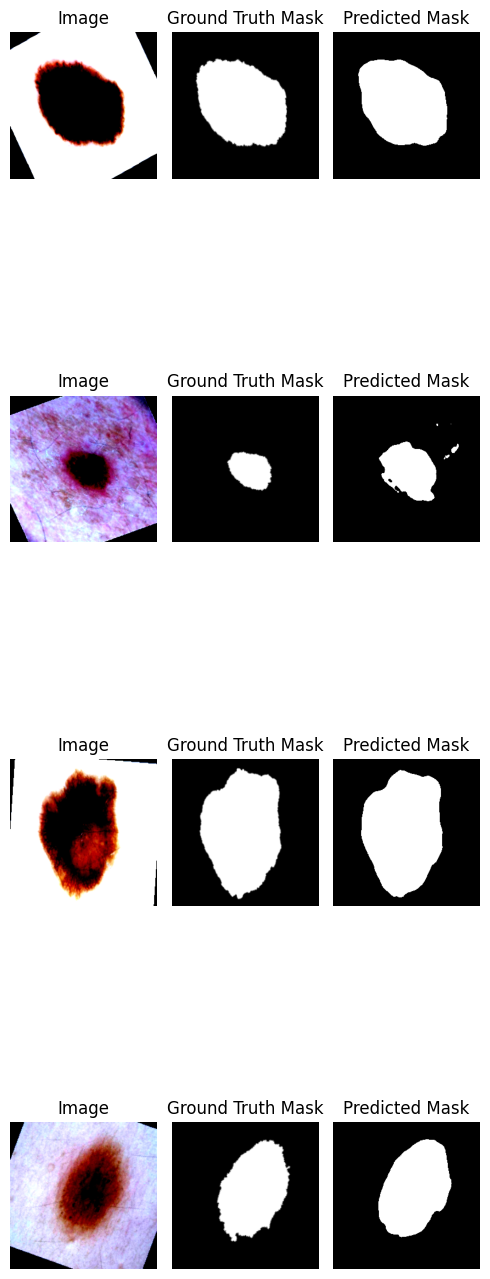

Batch Accuracy: 96.04%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# Function to visualize images, masks, predictions, and calculate accuracy
def visualize_results_with_accuracy(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode

    # Get a batch of images and masks
    images, masks = next(iter(dataloader))
    images = images.to(device)
    masks = masks.to(device)

    # Generate predictions
    with torch.no_grad():
        outputs = model(images)

    # Post-process the outputs to get binary masks
    preds = torch.sigmoid(outputs)
    preds = (preds > 0.5).float()  # Thresholding to get binary masks

    # Calculate accuracy for the batch
    correct_pixels = torch.sum(preds == masks)
    total_pixels = masks.numel()
    accuracy = (correct_pixels.item() / total_pixels) * 100  # Accuracy in percentage

    # Move data to CPU and convert to numpy arrays for visualization
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    # Plot images, masks, and predictions
    num_images = min(4, len(images))  # Display up to 4 images
    fig, axes = plt.subplots(num_images, 3, figsize=(5, num_images * 4))

    for i in range(num_images):
        # Original image
        axes[i, 0].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        # Ground truth mask
        axes[i, 1].imshow(masks[i][0], cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        # Predicted mask
        axes[i, 2].imshow(preds[i][0], cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print accuracy
    print(f"Batch Accuracy: {accuracy:.2f}%")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Visualize results for a few examples
visualize_results_with_accuracy(model, dataloaders['test'], device)


In [ ]:
import torch

def calculate_test_accuracy(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    running_corrects = 0  # To count correct pixel predictions
    total_pixels = 0  # To count total pixels in the dataset

    # Disable gradient calculations during evaluation
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            # Get model predictions
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Apply sigmoid and threshold at 0.5

            # Ensure preds and masks have the same dtype
            preds = preds.to(masks.dtype)

            # Calculate the number of correct pixels
            correct_pixels = torch.sum(preds == masks)
            running_corrects += correct_pixels.item()  # Convert tensor to a Python number

            # Calculate the total number of pixels
            total_pixels += masks.numel()  # Total number of pixels in the batch

    # Compute accuracy as a percentage
    test_accuracy = (running_corrects / total_pixels) * 100
    return test_accuracy

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Calculate accuracy on the test dataset
test_accuracy = calculate_test_accuracy(model, dataloaders['test'], device)
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 89.97%


In [ ]:
import torch

def calculate_f1_score(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    total_tp = 0  # True Positives
    total_fp = 0  # False Positives
    total_fn = 0  # False Negatives

    # Disable gradient calculations
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            # Get model predictions
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Apply sigmoid and threshold at 0.5

            # Convert preds to same type as masks
            preds = preds.to(masks.dtype)

            # Calculate True Positives, False Positives, and False Negatives
            tp = torch.sum((preds == 1) & (masks == 1)).item()  # Pixels correctly predicted as foreground
            fp = torch.sum((preds == 1) & (masks == 0)).item()  # Pixels wrongly predicted as foreground
            fn = torch.sum((preds == 0) & (masks == 1)).item()  # Pixels wrongly predicted as background

            total_tp += tp
            total_fp += fp
            total_fn += fn

    # Calculate Precision and Recall
    precision = total_tp / (total_tp + total_fp + 1e-8)  # Avoid division by zero
    recall = total_tp / (total_tp + total_fn + 1e-8)

    # Compute F1-score
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)

    return f1_score

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Calculate F1-score on the test dataset
test_f1_score = calculate_f1_score(model, dataloaders['test'], device)
print(f"Test F1-score: {test_f1_score:.4f}")


Test F1-score: 0.8965


In [ ]:
import torch

def calculate_iou(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    total_iou = 0  # Sum of IoUs for all batches
    num_batches = 0  # Count of batches processed

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            # Get model predictions
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Thresholding at 0.5

            # Convert preds to same type as masks
            preds = preds.to(masks.dtype)

            # Compute Intersection and Union
            intersection = torch.sum((preds == 1) & (masks == 1)).item()
            union = torch.sum((preds == 1) | (masks == 1)).item()

            # Avoid division by zero
            iou = intersection / (union + 1e-8)
            total_iou += iou
            num_batches += 1

    # Average IoU across batches
    mean_iou = total_iou / num_batches
    return mean_iou

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Calculate IoU on the test dataset
test_iou = calculate_iou(model, dataloaders['test'], device)
print(f"Test IoU: {test_iou:.4f}")


Test IoU: 0.7966
